# Challenge: Boston Marathon

Determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. 

Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

raw_data = pd.read_csv("./boston_2013.csv")
print(raw_data.shape[0], 'rows;', raw_data.shape[1], 'columns')
raw_data.head()

16164 rows; 21 columns


,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [2]:
df = raw_data.drop(columns=['name', 'division', 'bib', 'ctz', 'state' , 'city', 'genderdiv'], axis=1)

def assign_continent(country):
    if country in ['CAN', 'USA', 'MEX', 'BER', 'CRC', 'DOM', 'BAH', 'PAN', 'CAY', 'ESA', 'VGB', 'TCA']:
        return 'N. America'
    elif country in ['KEN', 'ETH', 'RSA']:
        return 'Africa'
    elif country in ['ECU', 'GUA', 'BRA', 'VEN', 'COL', 'PER', 'CHI', 'ARG', 'URU', 'TRI', 'ARU', 'BOL']:
        return 'S. America'
    elif country in ['JPN', 'HKG', 'KOR', 'SIN', 'CHN', 'UAE', 'ISR', 'TWN', 'IND', 'MAS', 'PHI', 'QAT']:
        return 'Asia'
    elif country in ['AUS', 'NZL']:
        return 'Oceania'
    else:
        return 'Europe'
    
df['continent'] = df['country'].apply(assign_continent)
df = df.drop(columns=['country'])
df.head()

,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k,continent
0,49.87,28,18.18,M,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55,N. America
1,77.27,30,30.90,M,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77,Africa
2,77.23,23,30.90,M,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78,Africa
3,50.50,32,18.73,M,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43,Oceania
4,48.75,39,18.18,M,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88,Asia


In [3]:
gender_contin_cols = ['gender', 'continent']
gender_contin_dummies = pd.get_dummies(df[gender_contin_cols])
df = pd.concat([df[df.columns.difference(gender_contin_cols)], gender_contin_dummies], axis=1)

df.head()

,10k,20k,25k,30k,35k,40k,5k,age,half,official,overall,pace,gender_F,gender_M,continent_Africa,continent_Asia,continent_Europe,continent_N. America,continent_Oceania,continent_S. America
0,18.18,38.80,49.87,62.07,74.73,85.55,8.90,28,40.93,90.90,9,3.47,0,1,0,0,0,1,0,0
1,30.90,61.52,77.27,92.97,108.78,124.77,15.90,30,64.90,132.50,5,5.07,0,1,1,0,0,0,0,0
2,30.90,61.53,77.23,92.72,108.68,123.78,15.93,23,64.92,130.37,1,4.98,0,1,1,0,0,0,0,0
3,18.73,39.88,50.50,61.35,73.00,83.43,8.98,32,42.00,88.43,5,3.38,0,1,0,0,0,0,1,0
4,18.18,38.55,48.75,59.92,71.68,81.88,8.92,39,40.57,87.22,3,3.33,0,1,0,1,0,0,0,0


## Data Visualizations

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


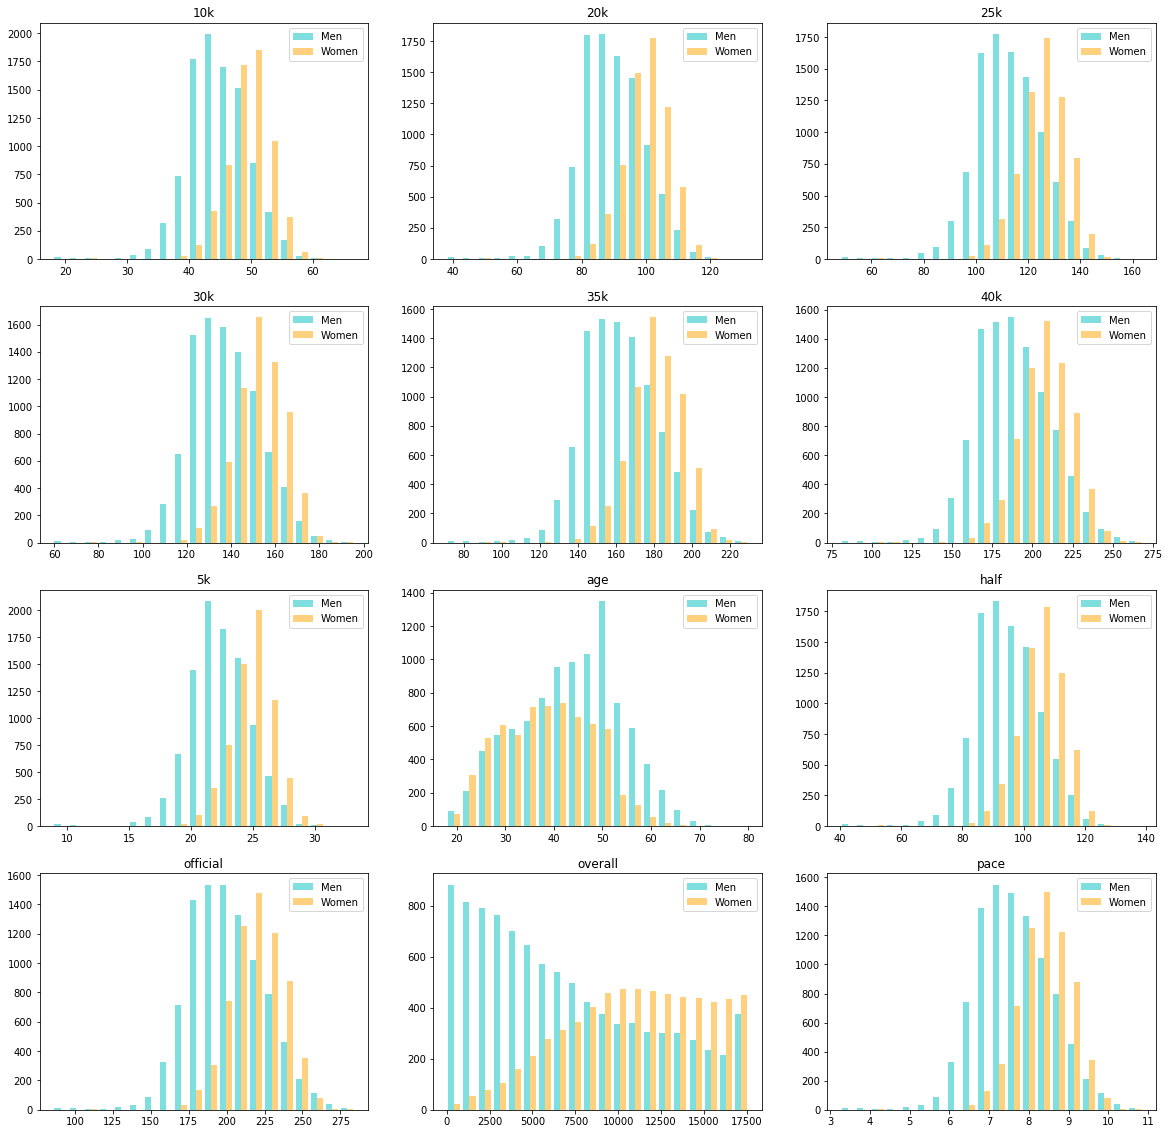

In [4]:
cols_to_norm = ['10k', '20k', '25k', '30k', '35k', '40k', '5k', 'age', 'half', 'official', 'overall', 'pace']

for col_to_norm in cols_to_norm:
    df[col_to_norm] = pd.to_numeric(df[col_to_norm], errors='coerce')

men = df[df['gender_M'] == 1]
women = df[df['gender_F'] == 1]

plt.figure(figsize=(20,20))

for idx, col in enumerate(cols_to_norm):
    plt.subplot(4, 3, idx + 1)
    plt.hist([men[col], women[col]], bins=20, alpha=0.5, color=['c', 'orange'], label=['Men', 'Women'])
    plt.legend()
    plt.title(col)

plt.show()

## K-Means

### 2 clusters

In [5]:
# Normalize data before clustering
df = df.dropna(subset=cols_to_norm)

cluster_df = df.copy()
cluster_df[cols_to_norm] = normalize(cluster_df[cols_to_norm])
    
cluster_df = pd.concat([cluster_df[cols_to_norm], cluster_df[cluster_df.columns.difference(cols_to_norm)]], axis=1)
print(cluster_df.shape[0], 'rows;', cluster_df.shape[1], 'columns')

cluster_df.head()

16054 rows; 20 columns


,10k,20k,25k,30k,35k,40k,5k,age,half,official,overall,pace,continent_Africa,continent_Asia,continent_Europe,continent_N. America,continent_Oceania,continent_S. America,gender_F,gender_M
0,0.101672,0.216989,0.278898,0.347126,0.417927,0.478438,0.049773,0.156590,0.228901,0.508358,0.050332,0.019406,0,0,0,1,0,0,0,1
1,0.117020,0.232980,0.292626,0.352083,0.411957,0.472512,0.060214,0.113612,0.245780,0.501786,0.018935,0.019200,1,0,0,0,0,0,0,1
2,0.118102,0.235172,0.295179,0.354382,0.415383,0.473096,0.060886,0.087908,0.248129,0.498283,0.003822,0.019034,1,0,0,0,0,0,0,1
3,0.105919,0.225524,0.285581,0.346938,0.412820,0.471802,0.050782,0.180962,0.237513,0.500077,0.028275,0.019114,0,0,0,0,1,0,0,1
4,0.104099,0.220737,0.279142,0.343102,0.410440,0.468845,0.051076,0.223314,0.232304,0.499422,0.017178,0.019068,0,1,0,0,0,0,0,1


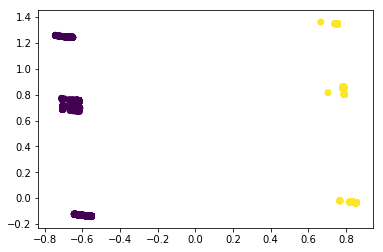

In [6]:
pca_2 = PCA(2).fit_transform(cluster_df)
kmeans_2_pred = KMeans(n_clusters=2, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_2_pred)
plt.show()

### 6 clusters

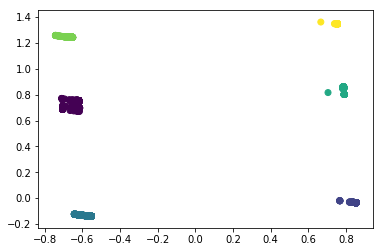

In [7]:
kmeans_6_pred = KMeans(n_clusters=6, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_6_pred)
plt.show()

## Mini-Batch K-Means

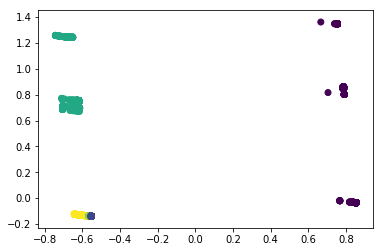

In [8]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=6, batch_size=200)
minibatch_6_pred = minibatchkmeans.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=minibatch_6_pred)
plt.show()

## Mean-Shift

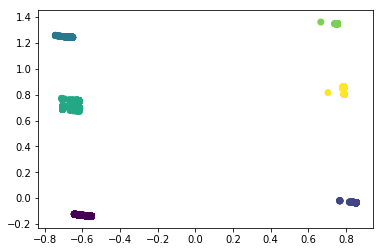

In [9]:
# Derive bandwidth # based on distances among datapoints
bandwidth = estimate_bandwidth(pca_2, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=ms_pred)
plt.show()

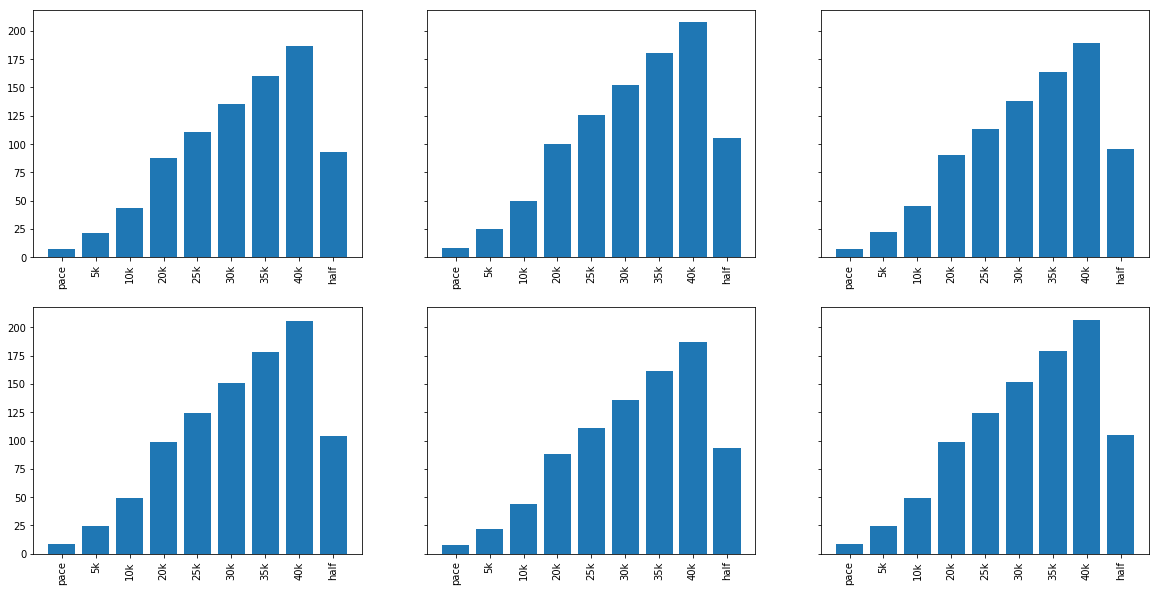

In [71]:
df['kmeans_6_pred'] = kmeans_6_pred

cluster_1 = df[df['kmeans_6_pred'] == 0].loc[:, df.columns != 'kmeans_6_pred']
cluster_2 = df[df['kmeans_6_pred'] == 1].loc[:, df.columns != 'kmeans_6_pred']
cluster_3 = df[df['kmeans_6_pred'] == 2].loc[:, df.columns != 'kmeans_6_pred']
cluster_4 = df[df['kmeans_6_pred'] == 3].loc[:, df.columns != 'kmeans_6_pred']
cluster_5 = df[df['kmeans_6_pred'] == 4].loc[:, df.columns != 'kmeans_6_pred']
cluster_6 = df[df['kmeans_6_pred'] == 5].loc[:, df.columns != 'kmeans_6_pred']
all_clusters = [[cluster_1, cluster_2, cluster_3], [cluster_4, cluster_5, cluster_6]]

# no 'overall' or 'official', as that is ordinal
time_cols = ['pace', '5k', '10k', '20k', '25k', '30k', '35k', '40k', 'half'] 

f, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 10))

for rowIdx in range(2):
    for colIdx in range(3):
        cluster = all_clusters[rowIdx][colIdx].mean()
#         TODO: put cluster in new dataframe and show dataframe
#         print(cluster)
        axes[rowIdx][colIdx].bar(cluster[time_cols].index, height=cluster[time_cols])
        
        for tick in axes[rowIdx][colIdx].get_xticklabels():
            tick.set_rotation(90)
    
plt.show()

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:850: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


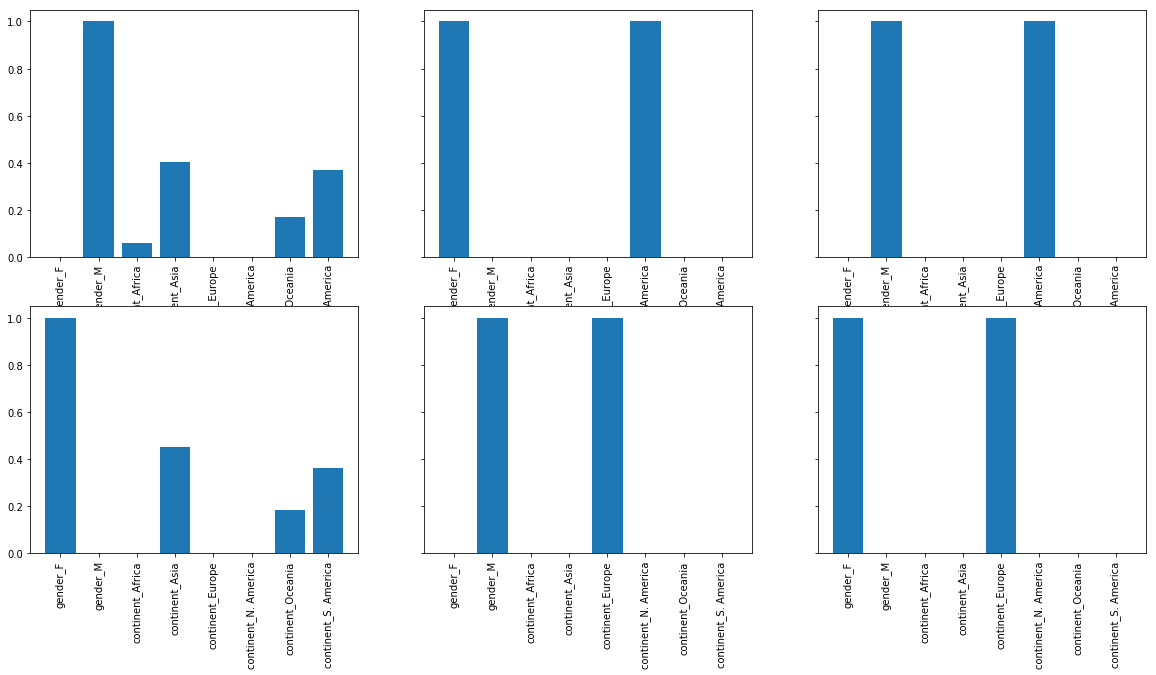

In [61]:
other_cols = list(filter(lambda x: x not in time_cols + ['overall', 'official', 'age'], df.columns))

f, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 10))

for rowIdx in range(2):
    for colIdx in range(3):
        cluster = all_clusters[rowIdx][colIdx].mean()
        axes[rowIdx][colIdx].bar(cluster[other_cols].index, height=cluster[other_cols])
        
        for tick in axes[rowIdx][colIdx].get_xticklabels():
            tick.set_rotation(90)
    
plt.show()

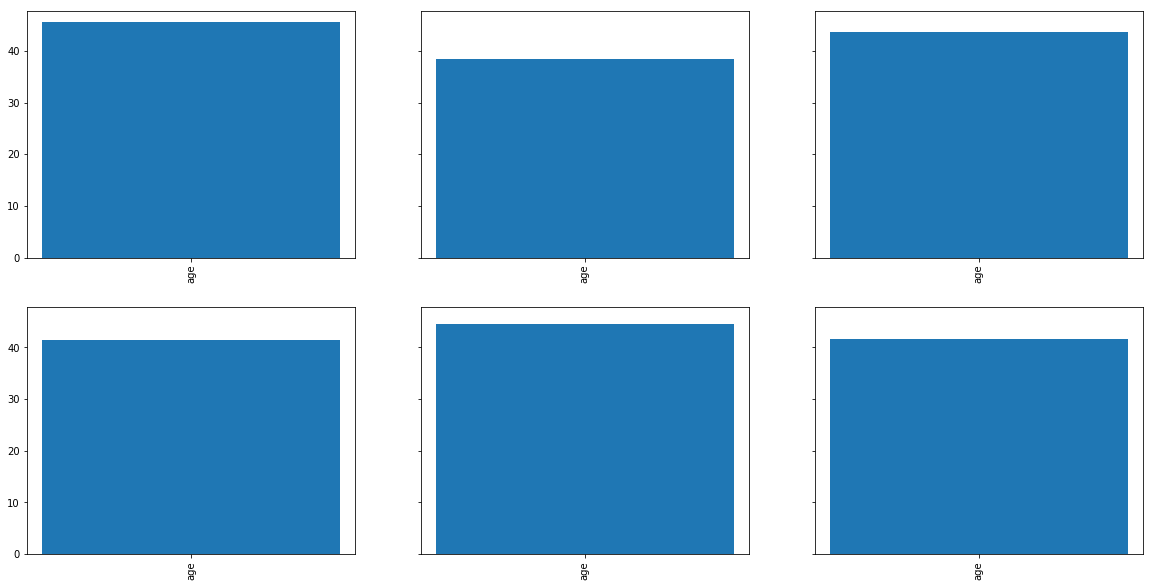

In [60]:
f, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 10))

for rowIdx in range(2):
    for colIdx in range(3):
        cluster = all_clusters[rowIdx][colIdx].mean()
        axes[rowIdx][colIdx].bar(cluster[['age']].index, height=cluster[['age']])
        
        for tick in axes[rowIdx][colIdx].get_xticklabels():
            tick.set_rotation(90)
    
plt.show()

## Conclusion

- 1 - Asian, South American, Oceanian, African - M, older, faster
- 2 - North American - F, younger, slower
- 3 - North American - M, older, faster
- 4 - Asian, South American, Oceanian - F, younger, slower
- 5 - European – M, older, faster
- 6 - European - F, younger, slower

Similar to our clustering graphs, it seems like there are 2 main groups – older & faster men vs. younger & slower women. 

Within the older & faster men group, there are 3 supgroups: 
- Asian, South American, Oceanian, African
- North American
- European

Within the younger & slower women group, there are 3 supgroups: 
- North American
- Asian, South American, Oceanian
- European